In [1]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fname = join(os.getcwd(),'data','data3SS2009.mat') # fname = caminho da pasta com arquivo

mat_contents = sio.loadmat(fname) # mat_contents carrega todos os dados do arquivo

dataset = mat_contents['dataset'] # Armazena os dados da coluna dataset

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

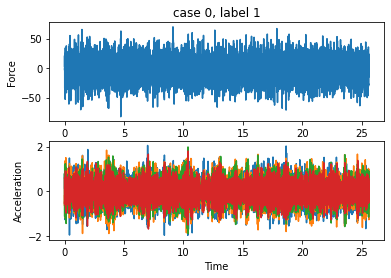

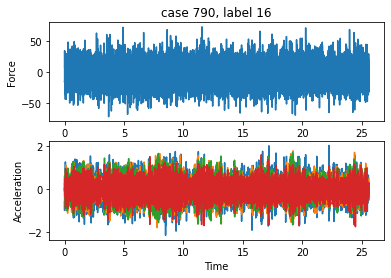

In [3]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [4]:
# Exercício 4.a.a

#loop feito para cada canal e cada sequência de medidas
#Importações indicadas no tutorial da página
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg  

Channels = [Ch2, Ch3, Ch4, Ch5]
X1 = []
n_lag = 30

for Channel in Channels:
    parameters = []
    for case in range(Nc):
        AR_Ch = AutoReg(Channel[:,case],lags=n_lag).fit()
        parameters.append(AR_Ch.params)
    parameters = np.vstack(tuple(parameters))
    print('Output shape = {}'.format(parameters.shape))
    X1.append(parameters)

X1 = np.hstack(X1)
X1.shape #Formato da matriz final

Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)


(850, 124)

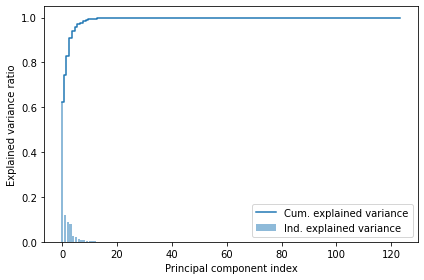

(850, 10)

In [5]:
# Exercício 4.a.b
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X1)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

X1_reduced=pca.fit_transform(X1)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
X2=X1_reduced[:,0:componentes]
X2.shape

# X3 -> T2(T1(X3)) -> OUTPUT (1 a 17)

In [6]:
# Exercício 4.b

# Utilizando métodos descritos em:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
# E no slide 12 da aula 2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
X1s = scaler.fit_transform(X1)
X2s = scaler.fit_transform(X2)

indDam = y > 9

dfARed = pd.concat([pd.DataFrame(X1s),pd.DataFrame({'target':indDam})], axis=1)
dfPCA = pd.concat([pd.DataFrame(X2s),pd.DataFrame({'target':indDam})], axis=1)

dfPCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-0.252236,-0.312300,-0.234238,-0.012273,-0.129277,-0.010447,-0.085838,-0.070841,-0.195128,-0.051741
std,0.582294,0.450444,0.235347,0.427869,0.369069,0.354312,0.367903,0.350867,0.289218,0.342014
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.820990,-0.605487,-0.402430,-0.285883,-0.381873,-0.189913,-0.359643,-0.277146,-0.345575,-0.254795
50%,-0.425344,-0.470663,-0.246178,0.038969,-0.206845,-0.028918,-0.119966,-0.071913,-0.167205,-0.007364
75%,0.352590,-0.222251,-0.077246,0.292005,0.141888,0.149019,0.141957,0.119499,-0.040920,0.172722
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Aula 4 - preparação
# Definições dos modelos
from sklearn.model_selection import (train_test_split, RepeatedKFold, RandomizedSearchCV)

from scipy import stats
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.metrics import (accuracy_score)
import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

models = []
models.append(("DTC",DecisionTreeClassifier())) 
models.append(("RFC",RandomForestClassifier())) 


nomes_modelos = ["DTC", "RFC"]
param_grids = []

param_grids.append( #Decision Tree Classifier
    [
        {
            "DTC__criterion": ['gini','entropy','log_loss'],
            "DTC__max_depth": stats.randint(2,8),
            'DTC__min_samples_split': stats.randint(2,10), 
            'DTC__min_samples_leaf': stats.randint(1,10), 
            'DTC__max_features': stats.uniform(),      
            'DTC__max_leaf_nodes': stats.randint(10,150), 
        }
        
    ]
)

param_grids.append( #Random Forest Classifier
    [
        {
            'RFC__n_estimators'           : stats.randint(3,20), #Numero de arvores
            'RFC__criterion'              : ['gini', 'entropy'],
            'RFC__max_depth'              : stats.randint(2,20), #maxima profundidade da arvore
            'RFC__min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
            'RFC__min_samples_leaf'       : stats.randint(2,20), #minima quantidade de amostras por folha
            'RFC__max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
            'RFC__max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas

        }
        
    ]
)



In [9]:
# Exercício Aula 5 

i=42
pctHoldout = 0.4
kfolds =  5
nkiter = 50
n_search_iter = 10

X_train, X_test, y_train, y_test = train_test_split(X2s,y, test_size=pctHoldout, random_state=i) 



In [10]:
# Exercício aula 5

for k in range(2):
    rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=i)
    clf = Pipeline([("scaler",StandardScaler()),(models[k])])
    param_grid = param_grids[k]
    random_search = RandomizedSearchCV(clf,verbose=0,scoring="accuracy",
        param_distributions=param_grid, n_iter=10,n_jobs=-1,cv=rkf,random_state=i)
    ti = datetime.now()
    random_search.fit(X_train,y_train)
    perf_train = random_search.score(X_train,y_train)
    tf1 = datetime.now()
    random_search.fit(X_test,y_test)
    perf_test = random_search.score(X_test,y_test)
    yh = random_search.predict(X_test)
#     perf_test_final = random_search.score()
    
    print(f"Modelo: {nomes_modelos[k]}\n")
    print(f"Performance no treino = {perf_train*100:.2f}%.")
    print(f"Performance no teste = {perf_test*100:.2f}%.")
#     print(f"performance final = {perf_test_final:.2f}")
    print(f"Demorou {tf1-ti} segundos.\n")
    
    print("Resultados dos parâmetros:")
    for par in random_search.best_params_.keys():
        print(f"Parâmetro {par}: {random_search.best_params_[par]}")
    print("------------------------------------------------------")

Modelo: DTC

Performance no treino = 37.65%.
Performance no teste = 53.53%.
Demorou 0:00:08.716796 segundos.

Resultados dos parâmetros:
Parâmetro DTC__criterion: gini
Parâmetro DTC__max_depth: 5
Parâmetro DTC__max_features: 0.18223608778806233
Parâmetro DTC__max_leaf_nodes: 141
Parâmetro DTC__min_samples_leaf: 2
Parâmetro DTC__min_samples_split: 7
------------------------------------------------------
Modelo: RFC

Performance no treino = 97.06%.
Performance no teste = 96.76%.
Demorou 0:00:27.228059 segundos.

Resultados dos parâmetros:
Parâmetro RFC__criterion: gini
Parâmetro RFC__max_depth: 16
Parâmetro RFC__max_features: 0.7319939418114051
Parâmetro RFC__max_leaf_nodes: 30
Parâmetro RFC__min_samples_leaf: 8
Parâmetro RFC__min_samples_split: 12
Parâmetro RFC__n_estimators: 13
------------------------------------------------------


In [25]:
# Exercício aula 5

# n_iter = 100
for k in range(2):
    t0 = datetime.now()
    rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=i)
    clf = Pipeline([("scaler",StandardScaler()),(models[k])])
    param_grid = param_grids[k]
    random_search = RandomizedSearchCV(clf,verbose=0,scoring="accuracy",
        param_distributions=param_grid, n_iter=100,n_jobs=-1,cv=rkf,random_state=i)
    random_search.fit(X_train,y_train)
    perf_train = random_search.score(X_train,y_train)
    random_search.fit(X_test,y_test)
    perf_test = random_search.score(X_test,y_test)
    t1 = datetime.now()
    print(f"Modelo: {nomes_modelos[k]}\n")
    print(f"Performance no treino = {perf_train*100:.2f}%.")
    print(f"Performance no teste = {perf_test*100:.2f}%.")
    print(f"Demorou {t1-t0} segundos.\n")
    
    print("Resultados dos parâmetros:")
    for par in random_search.best_params_.keys():
        print(f"Parâmetro {par}: {random_search.best_params_[par]}")
    print("------------------------------------------------------")

Modelo: DTC

Performance no treino = 95.10%.
Performance no teste = 96.47%.
Demorou 0:01:35.147478 segundos.

Resultados dos parâmetros:
Parâmetro DTC__criterion: entropy
Parâmetro DTC__max_depth: 5
Parâmetro DTC__max_features: 0.8264574661077416
Parâmetro DTC__max_leaf_nodes: 95
Parâmetro DTC__min_samples_leaf: 3
Parâmetro DTC__min_samples_split: 2
------------------------------------------------------
Modelo: RFC

Performance no treino = 98.43%.
Performance no teste = 99.71%.
Demorou 0:09:35.391854 segundos.

Resultados dos parâmetros:
Parâmetro RFC__criterion: entropy
Parâmetro RFC__max_depth: 11
Parâmetro RFC__max_features: 0.6258599157142364
Parâmetro RFC__max_leaf_nodes: 105
Parâmetro RFC__min_samples_leaf: 2
Parâmetro RFC__min_samples_split: 6
Parâmetro RFC__n_estimators: 15
------------------------------------------------------


In [12]:
resultados = {}
resultados["DTC"] = {}
resultados["DTC"]["DTC__criterion"] = []
resultados["DTC"]["DTC__max_depth"] = []
resultados["DTC"]["DTC__min_samples_split"] = []
resultados["DTC"]["DTC__min_samples_leaf"] = []
resultados["DTC"]["DTC__max_features"] = []
resultados["DTC"]["DTC__max_leaf_nodes"] = []
resultados["DTC"]["Train_score"] = []
resultados["DTC"]["Test_score"] = []

resultados["RFC"] = {}
resultados["RFC"]["RFC__n_estimators"] = []
resultados["RFC"]["RFC__criterion"] = []
resultados["RFC"]["RFC__max_depth"] = []
resultados["RFC"]["RFC__min_samples_split"] = []
resultados["RFC"]["RFC__min_samples_leaf"] = []
resultados["RFC"]["RFC__max_features"] = []
resultados["RFC"]["RFC__max_leaf_nodes"] = []
resultados["RFC"]["Train_score"] = []
resultados["RFC"]["Test_score"] = []

print(json.dumps(resultados, indent=4))




{
    "DTC": {
        "DTC__criterion": [],
        "DTC__max_depth": [],
        "DTC__min_samples_split": [],
        "DTC__min_samples_leaf": [],
        "DTC__max_features": [],
        "DTC__max_leaf_nodes": [],
        "Train_score": [],
        "Test_score": []
    },
    "RFC": {
        "RFC__n_estimators": [],
        "RFC__criterion": [],
        "RFC__max_depth": [],
        "RFC__min_samples_split": [],
        "RFC__min_samples_leaf": [],
        "RFC__max_features": [],
        "RFC__max_leaf_nodes": [],
        "Train_score": [],
        "Test_score": []
    }
}


In [14]:
seeds = [3,23,43,53,73] #seeds aleatórias para testar repetibilidade

for s in seeds:
    print(f"random_state={s}")
    for k in range(2):
        rkf = RepeatedKFold(n_splits=5, n_repeats=50, random_state=s)
        clf = Pipeline([("scaler",StandardScaler()),(models[k])])
        param_arq = resultados[nomes_modelos[k]]
        param_grid = param_grids[k]
        random_search = RandomizedSearchCV(clf,verbose=0,scoring="accuracy",
            param_distributions=param_grid, n_iter=10,n_jobs=-1,cv=rkf,random_state=s)
        t0 = datetime.now()
        random_search.fit(X_train,y_train)
        param_arq["Train_score"].append(random_search.score(X_train,y_train))
        t1 = datetime.now()
        random_search.fit(X_test,y_test)
        param_arq["Test_score"].append(random_search.score(X_test,y_test))
        
        print(f"Avaliação do Modelo: {nomes_modelos[k]}\n")
        print(f"Performance no treino = {random_search.score(X_train,y_train)*100:.2f}%.")
        print(f"Performance no teste = {random_search.score(X_test,y_test)*100:.2f}%.")
        print(f"Demorou {t1-t0} segundos.\n")
    
        print("Resultados dos parâmetros:")
        for par in random_search.best_params_.keys():
            print(f"Parâmetro {par}: {random_search.best_params_[par]}")
            param_arq[par].append(random_search.best_params_[par])
        print("------------------------------------------------------")
        
        

random_state=3
Avaliação do Modelo: DTC

Performance no treino = 89.22%.
Performance no teste = 98.24%.
Demorou 0:00:05.411292 segundos.

Resultados dos parâmetros:
Parâmetro DTC__criterion: entropy
Parâmetro DTC__max_depth: 7
Parâmetro DTC__max_features: 0.7184220249681447
Parâmetro DTC__max_leaf_nodes: 38
Parâmetro DTC__min_samples_leaf: 8
Parâmetro DTC__min_samples_split: 8
------------------------------------------------------
Avaliação do Modelo: RFC

Performance no treino = 94.71%.
Performance no teste = 97.06%.
Demorou 0:00:20.243678 segundos.

Resultados dos parâmetros:
Parâmetro RFC__criterion: entropy
Parâmetro RFC__max_depth: 6
Parâmetro RFC__max_features: 0.2917927742254326
Parâmetro RFC__max_leaf_nodes: 90
Parâmetro RFC__min_samples_leaf: 2
Parâmetro RFC__min_samples_split: 18
Parâmetro RFC__n_estimators: 14
------------------------------------------------------
random_state=23
Avaliação do Modelo: DTC

Performance no treino = 91.37%.
Performance no teste = 99.71%.
Demorou

In [15]:
pd.DataFrame(resultados['DTC'])

,DTC__criterion,DTC__max_depth,DTC__min_samples_split,DTC__min_samples_leaf,DTC__max_features,DTC__max_leaf_nodes,Train_score,Test_score
0,entropy,7,8,8,0.718422,38,0.962745,0.958824
1,entropy,7,8,8,0.718422,38,0.939216,0.982353
2,entropy,7,3,1,0.996866,31,0.986275,0.997059
3,entropy,5,2,8,0.859137,120,0.956863,0.961765
4,entropy,7,2,1,0.561166,73,0.962745,0.997059
5,entropy,7,5,5,0.655225,114,0.950980,0.967647


In [16]:
pd.DataFrame(resultados['RFC'])

,RFC__n_estimators,RFC__criterion,RFC__max_depth,RFC__min_samples_split,RFC__min_samples_leaf,RFC__max_features,RFC__max_leaf_nodes,Train_score,Test_score
0,14,entropy,6,18,2,0.291793,90,0.980392,0.970588
1,14,entropy,6,18,2,0.291793,90,0.982353,0.970588
2,15,entropy,9,12,4,0.756127,128,0.982353,0.991176
3,19,gini,13,6,6,0.056885,127,0.970588,0.979412
4,16,entropy,6,4,3,0.157620,71,0.962745,0.985294
5,9,gini,16,3,5,0.607897,146,0.972549,0.976471


In [23]:
# Comparando com os defaults

clf_DTC_default = DecisionTreeClassifier().fit(X1s,y)
DTC_yh_default = clf_DTC_default.predict(X1s)
prec_DTC_default = accuracy_score(y, DTC_yh_default)
print(f"A precisão do modelo DTC com parâmetros default foi: {prec_DTC_default*100:.2f}%")

clf_DTC_otimizado = DecisionTreeClassifier(criterion='entropy',max_depth=7,min_samples_split=3,min_samples_leaf=1, max_features=0.996866,max_leaf_nodes=31).fit(X1s,y)
DTC_yh_otimizado = clf_DTC_otimizado.predict(X1s)
prec_DTC_otimizado = accuracy_score(y, DTC_yh_otimizado)
print(f"A precisão do modelo DTC com parâmetros otimizados foi: {prec_DTC_otimizado*100:.2f}%")


A precisão do modelo DTC com parâmetros default foi: 100.00%
A precisão do modelo DTC com parâmetros otimizados foi: 100.00%


In [24]:
# Comparando com os defaults

clf_RFC_default = RandomForestClassifier().fit(X2s,y)
RFC_yh_default = clf_RFC_default.predict(X2s)
prec_RFC_default = accuracy_score(y, RFC_yh_default)
print(f"A precisão do modelo RFC com parâmetros default foi: {prec_RFC_default*100:.2f}%")

clf_RFC_otimizado = RandomForestClassifier(criterion='entropy',max_depth=9,min_samples_split=12,min_samples_leaf=4, max_features=0.756127,max_leaf_nodes=128).fit(X2s,y)
RFC_yh_otimizado = clf_RFC_otimizado.predict(X2s)
prec_RFC_otimizado = accuracy_score(y, RFC_yh_otimizado)
print(f"A precisão do modelo RFC com parâmetros otimizados foi: {prec_RFC_otimizado*100:.2f}%")



A precisão do modelo RFC com parâmetros default foi: 100.00%
A precisão do modelo RFC com parâmetros otimizados foi: 98.94%
